In [1]:
import pandas as pd
import geopandas as gpd
import os
import requests
import esda
import libpysal
import multiprocessing as mp
import itertools
import pygeos
import subprocess
import json
import sys

In [2]:
def resample_raster(rasterfile_path, filename, target_path, rescale_factor):
    # first determine pixel size for resampling
    xres = 0
    yres = 0
    
    out = subprocess.run(["gdalinfo","-json",rasterfile_path],stdout=subprocess.PIPE)
    raster_meta = json.loads(out.stdout.decode('utf-8'))
    if 'geoTransform' in raster_meta:
        xres = raster_meta['geoTransform'][1]
        yres = raster_meta['geoTransform'][5]
        xres = xres * rescale_factor
        yres = yres * rescale_factor

    if (xres != 0) and (yres != 0):
        # resample raster
        save_path = target_path +"/"+ filename + f"_resample.tiff"
        subprocess.run(["gdalwarp","-r","bilinear","-of","GTiff","-tr",str(xres),str(yres),rasterfile_path,save_path])

        return save_path, raster_meta
    

def polygonize_fim(rasterfile_path):

    # Extract target path and filename from the given raster file path
    target_path = '/'.join(rasterfile_path.split('/')[:-1])
    filename = rasterfile_path.split("/")[-1].split(".")[-2]

    # Define paths
    resample_path = target_path +"/"+ filename + f"_resample.tiff"
    reclass_file = target_path + "/" + filename + "_reclass.tiff"
    geojson_out = "%s/%s.json" % (target_path, filename)

    for temp_path_ in [resample_path, reclass_file, geojson_out]:
        if os.path.exists(temp_path_):
            os.remove(temp_path_)

    # Resample raster file to 10-times smaller
    resample_path, raster_meta = resample_raster(rasterfile_path, filename, target_path, rescale_factor=4)

    # Reclassify raster
    '''
    water_lvl = [0, 2, 6, 15, np.inf]  # Original inundation map value (underwater in feet)
    water_lvl_recls = [-9999, 1, 2, 3, 4]
    '''
    outfile = "--outfile="+reclass_file
    no_data_val = raster_meta['bands'][0]['noDataValue']
    # subprocess.run(["gdal_calc.py","-A",resample_path,outfile,"--calc=-9999*(A<=0)+1*((A>0)*(A<=2))+2*((A>2)*(A<=6))+3*((A>6)*(A<=15))+4*(A>15)","--NoDataValue=-9999"],stdout=subprocess.PIPE)
    subprocess.run(["gdal_calc.py","-A",resample_path,outfile,f"--calc=-9999*(A<=0)+1*(A>0)",f"--NoDataValue={no_data_val}"],stdout=subprocess.PIPE)
        
    # Polygonize the reclassified raster
    subprocess.run(["gdal_polygonize.py", reclass_file, "-b", "1", geojson_out, filename, "value"])

    inund_polygons = gpd.read_file(geojson_out)

    if inund_polygons.shape[0] != 0:
        inund_polygons = inund_polygons.loc[(inund_polygons['value'] != -9999) & (inund_polygons['value'] != 0)]  # Remove pixels of null value

        # drop invalid geometries
        inund_polygons = inund_polygons.loc[inund_polygons['geometry'].is_valid, :]

        # Coverage for each class of inundation map
        inund_per_cls = inund_polygons.dissolve(by='value')
        inund_per_cls.reset_index(inplace=True)

        # remove all temp files
        os.remove(resample_path)
        os.remove(reclass_file)
        os.remove(geojson_out)

        # inundation_per_cls: GeoDataFrame 
        return inund_per_cls

    else:
        return gpd.GeoDataFrame(data={'value': 1}, index=[0], geometry=[None])

    # inundation_per_cls: GeoDataFrame 
    return inund_per_cls


def fim_and_ellipse(dam_id, input_dir):
    
    sce_mh = {'loadCondition': 'MH', 'breachCondition': 'F'}  # Maximun Height scenario
    sce_tas = {'loadCondition': 'TAS', 'breachCondition': 'F'}  # Top of Active Storage scenario
    sce_nh = {'loadCondition': 'NH', 'breachCondition': 'F'}  # Normal Height scenario

    # Maximun Height scenario (weight: 1)
    fim_path_mh = f"{input_dir}/NID_FIM_{sce_mh['loadCondition']}_{sce_mh['breachCondition']}/{sce_mh['loadCondition']}_{sce_mh['breachCondition']}_{dam_id}.tiff"
    fim_gdf_mh = polygonize_fim(fim_path_mh)
    fim_gdf_mh['value_mh'] = fim_gdf_mh['value'] * 1
    fim_gdf_mh.drop(columns=['value'], inplace=True)

    # Top of Active Storage scenario (weight: 2)
    fim_path_tas = f"{input_dir}/NID_FIM_{sce_tas['loadCondition']}_{sce_tas['breachCondition']}/{sce_tas['loadCondition']}_{sce_tas['breachCondition']}_{dam_id}.tiff"
    fim_gdf_tas = polygonize_fim(fim_path_tas)
    fim_gdf_tas['value_tas'] = fim_gdf_tas['value'] * 1
    fim_gdf_tas.drop(columns=['value'], inplace=True)

    # Normal Height scenario (weight: 4)
    fim_path_nh = f"{input_dir}/NID_FIM_{sce_nh['loadCondition']}_{sce_nh['breachCondition']}/{sce_nh['loadCondition']}_{sce_nh['breachCondition']}_{dam_id}.tiff"
    fim_gdf_nh = polygonize_fim(fim_path_nh)
    fim_gdf_nh['value_nh'] = fim_gdf_nh['value'] * 1
    fim_gdf_nh.drop(columns=['value'], inplace=True)

    # Find intersections of inundated area across multiple scenarios
    temp_fim_gdf = gpd.overlay(fim_gdf_nh, fim_gdf_tas, how='union')
    fim_gdf = gpd.overlay(temp_fim_gdf, fim_gdf_mh, how='union')
    fim_gdf.fillna(0, inplace=True)

    # Sum values (1: MH only, 2: TAS only, 3: MH + TAS, 4: NH only, 5: MH + NH, 6: TAS + NH, 7: MH + TAS + NH)
    fim_gdf['value'] = fim_gdf.apply(lambda x:x['value_mh'] + x['value_tas'] + x['value_nh'], axis=1)
    fim_gdf.drop(columns=['value_mh', 'value_tas', 'value_nh'], inplace=True)
    fim_gdf['Dam_ID'] = dam_id
        
    return fim_gdf


def state_num_related_to_fim(fim_gdf, tract_gdf):
    
    tract_geoms = pygeos.from_shapely(tract_gdf['geometry'].values)
    tract_geoms_tree = pygeos.STRtree(tract_geoms, leafsize=50)

    fim_geom_union = pygeos.from_shapely(fim_gdf['geometry'].unary_union)    
    query_intersect = tract_geoms_tree.query(fim_geom_union, predicate='intersects')
    tract_gdf = tract_gdf.loc[query_intersect]

    tract_gdf['STATE'] = tract_gdf.apply(lambda x:x['GEOID'][0:2], axis=1)
    unique_state = tract_gdf['STATE'].unique()
    
    # return type: list
    return unique_state
    

def extract_fim_geoid(dam_id, input_dir, tract_gdf):
    print(f'{dam_id}: Step 1, 1/4, Identifying associated regions')
    fim_gdf = fim_and_ellipse(dam_id, input_dir)

    print(f'{dam_id}: Step 1, 2/4, Search states associated')
    fim_state = state_num_related_to_fim(fim_gdf, tract_gdf)
    print(f'-- {dam_id} impacts {len(fim_state)} States, {fim_state}')

    if len(fim_state) == 1: # If only one state is associated with the inundation mapping
        census_gdf = gpd.read_file(f'{input_dir}/census_geometry/tl_2020_{fim_state[0]}_tabblock20.geojson')
    elif len(fim_state) >= 2: # If multiple states are associated with the inundation mapping
        census_gdf = pd.DataFrame()
        for state_num in fim_state:
            temp_gdf = gpd.read_file(f'{input_dir}/census_geometry/tl_2020_{state_num}_tabblock20.geojson')
            census_gdf = pd.concat([temp_gdf, census_gdf]).reset_index(drop=True)
        census_gdf = gpd.GeoDataFrame(census_gdf, geometry=census_gdf['geometry'], crs="EPSG:4326")
    else:
        raise AttributeError('NO STATE is related to Inundation Mapping')

    # Destination dataframe to save the results
    print(f"{dam_id}: Step 1, 3/4, Extracting GEOID of census blocks")
    fim_geoid_df = pd.DataFrame({'Dam_ID': pd.Series(dtype='str'),
                                'GEOID': pd.Series(dtype='str'),
                                'Class': pd.Series(dtype='str')}
                                )    

    # Create STRtree for census_gdf
    census_geoms = pygeos.from_shapely(census_gdf['geometry'].values)
    census_geoms_tree = pygeos.STRtree(census_geoms, leafsize=50)

    # Extract census tract intersecting with each class of inundation map
    for water_cls in fim_gdf['value'].unique():
        fim_geom_ = pygeos.from_shapely(fim_gdf.loc[fim_gdf['value'] == water_cls, 'geometry'].unary_union)
        query_fim_geom_ = census_geoms_tree.query(fim_geom_, predicate='intersects')
        fim_geoid_ = census_gdf.loc[query_fim_geom_]

        for geoid_ in fim_geoid_['GEOID'].to_list():
            new_row = pd.DataFrame({'Dam_ID': dam_id, 
                                    'GEOID': geoid_, 
                                    'Class': water_cls}, 
                                    index=[0]
                                    )
            fim_geoid_df = pd.concat([new_row, fim_geoid_df]).reset_index(drop=True)

    print(f"{dam_id}: Step 1, 4/4, Assigning geometry to census blocks")
    fim_geoid_gdf = fim_geoid_df.merge(census_gdf, on='GEOID')
    fim_geoid_gdf = gpd.GeoDataFrame(fim_geoid_gdf, geometry=fim_geoid_gdf['geometry'], crs='EPSG:4326')
    fim_geoid_gdf['Class'] = fim_geoid_gdf['Class'].astype(int)
    fim_geoid_gdf = fim_geoid_gdf.groupby(['Dam_ID', 'GEOID'], 
                                    group_keys=False).apply(lambda x:x.loc[x['Class'].idxmax()]
                                                            ).reset_index(drop=True)
    fim_geoid_gdf = fim_geoid_gdf.set_crs(epsg=4326)

    return fim_geoid_gdf, fim_gdf

In [3]:
data_dir = os.getcwd()

sce_mh = {'loadCondition': 'MH', 'breachCondition': 'F'}  # Maximun Height scenario
sce_tas = {'loadCondition': 'TAS', 'breachCondition': 'F'}  # Top of Active Storage scenario
sce_nh = {'loadCondition': 'NH', 'breachCondition': 'F'}  # Normal Height scenario

# Find the list of dams in the input folder
fed_dams = pd.read_csv('./nid_available_scenario.csv')

# Remove dams with error (fim is too small to generate)
fed_dams = fed_dams.loc[fed_dams['ID'] != 'CO01283S001']

# Select only Fed Dams that have inundation maps.
for sce in [sce_mh, sce_tas, sce_nh]:
    fed_dams = fed_dams.loc[fed_dams[f'{sce["loadCondition"]}_{sce["breachCondition"]}'] == True]
    fed_dams = fed_dams.loc[fed_dams.apply(lambda x: True 
                                        if os.path.exists(os.path.join(data_dir, 
                                        f'NID_FIM_{sce["loadCondition"]}_{sce["breachCondition"]}', 
                                        f'{sce["loadCondition"]}_{sce["breachCondition"]}_{x["ID"]}.tiff')
                                        ) else False, axis=1)].reset_index(drop=True)
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
print(f'Total Dams: {fed_dams.shape[0]}')

Total Dams: 345


In [4]:
# Census tract to find state associated with fim of each dam
tract = gpd.read_file(os.path.join(data_dir, 'census_geometry', 'census_tract_from_api.geojson'))

In [5]:
dam_id = 'TX00018'

In [6]:
census_dic = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}


fim_geoid_gdf, fim_gdf = extract_fim_geoid(dam_id, data_dir, tract)
fim_geoid_gdf
# mi_gdf, lm_gdf = spatial_correlation(dam_id, fed_dams, fim_geoid_gdf, census_dic, API_Key)

TX00018: Step 1, 1/4, Identifying associated regions
Creating output file that is 10083P x 9787L.
Processing /Users/jparkgeo/Git_Repo/population_vulnerable_to_dam_failure/NID_FIM_MH_F/MH_F_TX00018.tiff [1/1] : 0Using internal nodata values (e.g. -9999) for image /Users/jparkgeo/Git_Repo/population_vulnerable_to_dam_failure/NID_FIM_MH_F/MH_F_TX00018.tiff.
Copying nodata values from source /Users/jparkgeo/Git_Repo/population_vulnerable_to_dam_failure/NID_FIM_MH_F/MH_F_TX00018.tiff to destination /Users/jparkgeo/Git_Repo/population_vulnerable_to_dam_failure/NID_FIM_MH_F/MH_F_TX00018_resample.tiff.
...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...Several drivers matching json extension. Using GeoJSON
Creating output /Users/jparkgeo/Git_Repo/population_vulnerable_to_dam_failure/NID_FIM_MH_F/MH_F_TX00018.json of format GeoJSON.
100 - done.
Creating output file that is 10083P x 9787L.
Processing /Users/jparkgeo/Git_Repo/population_vu

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_28447/565930278.py:106: UserWarning: `keep_geom_type=True` in overlay resulted in 7894 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  fim_gdf = gpd.overlay(temp_fim_gdf, fim_gdf_mh, how='union')


TX00018: Step 1, 2/4, Search states associated
-- TX00018 impacts 1 States, ['48']
TX00018: Step 1, 3/4, Extracting GEOID of census blocks
TX00018: Step 1, 4/4, Assigning geometry to census blocks


,Dam_ID,GEOID,Class,HOUSING20,POP20,geometry
0,TX00018,480396619021162,1,0,0,"POLYGON ((-95.54983 29.43844, -95.54754 29.438..."
1,TX00018,480396619021165,1,0,0,"POLYGON ((-95.55541 29.42554, -95.55237 29.427..."
2,TX00018,480396619021167,1,0,0,"POLYGON ((-95.55123 29.43129, -95.55105 29.432..."
3,TX00018,480396619021168,1,0,0,"POLYGON ((-95.55641 29.42461, -95.55594 29.425..."
4,TX00018,481576715011001,1,103,272,"POLYGON ((-95.58223 29.60622, -95.58194 29.606..."
...,...,...,...,...,...,...
22387,TX00018,482019807001099,2,2,2,"POLYGON ((-95.36492 29.75696, -95.36406 29.756..."
22388,TX00018,482019807001100,2,0,19,"POLYGON ((-95.36551 29.75621, -95.36464 29.755..."
22389,TX00018,482019807001101,2,0,0,"POLYGON ((-95.36640 29.75673, -95.36551 29.756..."
22390,TX00018,482019807001102,2,52,0,"POLYGON ((-95.36698 29.75599, -95.36610 29.755..."


In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

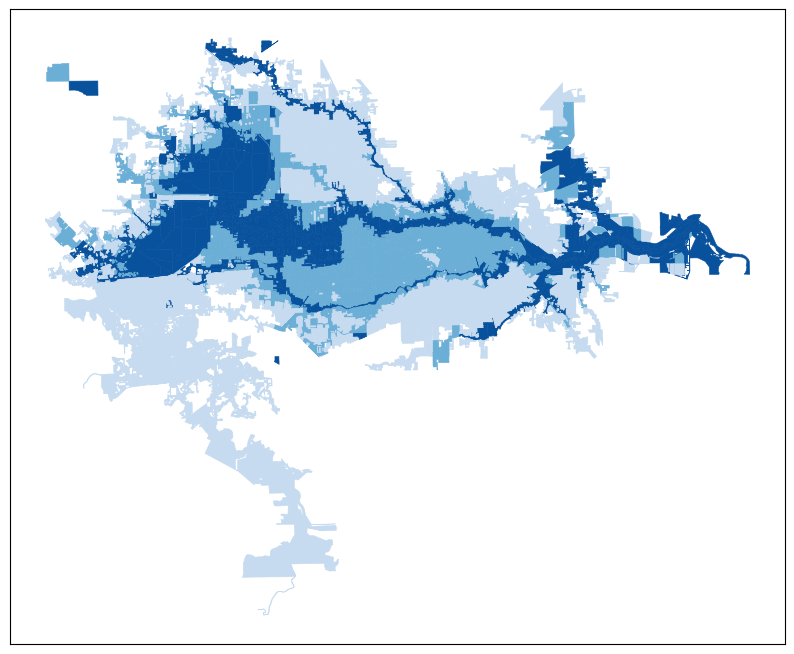

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

color_brewer = ['#c6dbef','#6baed6','#08519c']
# ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
# color_brewer.reverse()
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=3)
# fim_geoid_gdf = fim.to_crs(epsg=4326)

fim_geoid_gdf.plot('Class', ax=ax, cmap=cm, edgecolor="face", linewidth=0.4)
# fim_geoid_gdf.boundary.plot(ax=ax, linewidth=0.05, color='black')
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)
plt.show()

<Axes: >

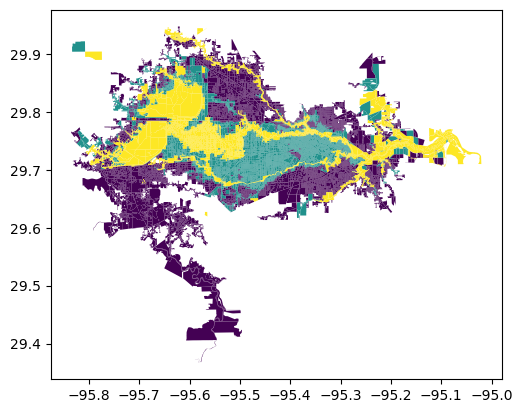

In [7]:
fim_geoid_gdf.plot('Class')